In [2]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import json
import warnings
from os import listdir
from os.path import isfile,join
import datetime
import requests
from sklearn.metrics import r2_score, accuracy_score
import catboost
import matplotlib as mpl
import sys
sys.path.append('.')
from src.utils import collect_data

In [3]:
collect_datasets = collect_data.DataCollection()

In [6]:
df_mobility = collect_datasets.get_mobility_data()
df_county_spending = collect_datasets.get_spend_data()
df_covid = collect_datasets.combine_covid_data()
df_weather = collect_datasets.combine_weather(df_mobility,df_covid)
df_county = collect_datasets.combined_county_data()

Getting Weather Data
Weather Data seems to be updated
Finised Records =  500
Finised Records =  1000
Finised Records =  1500
Finised Records =  2000
Finised Records =  2500
Finised Records =  3000


In [7]:
def get_model_df(df_weather, df_mob,df_covid,df_demographics,covid=False):
    df_mob = df_mob.dropna()
    covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
    if covid:
        df_mob_covid = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='inner')
        df_mob_covid = df_mob_covid[df_mob_covid.date >covid_date]
    else:
        df_mob_covid = df_mob[df_mob.date < covid_date]
        
    df_mob_covid_weather = pd.merge(left = df_mob_covid, right = df_weather, on =['date', 'fips'])
    df_all = pd.merge(left = df_mob_covid_weather.drop(columns=['State Postal Code', 'Level']), 
                      right = df_demographics, on = ['fips'])
    df_all['party'] =df_all['party'].fillna('republican')
    return df_all

In [8]:
def run_model_class(df,name,target_var,remove_col_list,task_type='GPU',max_depth= 6):
    
    remove_cols = ['date','fips','COUNTY','YEAR','NAME_E' ] + remove_col_list
    
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=[target_var])
    y =df_final[[target_var]]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("weekday"),
                 X.columns.get_loc("weekend"),X.columns.get_loc("party")]
    cb_model = catboost.CatBoostClassifier(task_type=task_type, n_estimators=250, eval_metric='Accuracy',
                                      max_depth=max_depth,devices='0',learning_rate=0.3,
                                          verbose=50,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(accuracy_score(y_test,y_pred_cb),2))
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb,cb_model


In [9]:
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
date_min = covid_date - datetime.timedelta(days=365)
date_max = df_mobility.date.max()- datetime.timedelta(days=365)
df_pre = df_mobility[(df_mobility.date>=date_min )&(df_mobility.date <= date_max)]
print('Pre Covid Max Trip Type per County per Date')
print(df_pre['Max_Trip_Type'].value_counts()*100/len(df_pre))


Pre Covid Max Trip Type per County per Date
Number of Trips 1-3           61.838172
Number of Trips <1            20.763397
Number of Trips 10-25         11.909543
Number of Trips 5-10           3.649469
Number of Trips 3-5            0.915526
Number of Trips 25-50          0.790338
Number of Trips 50-100         0.090404
Population Staying at Home     0.041182
Number of Trips 100-250        0.001477
Number of Trips >=500          0.000328
Number of Trips 250-500        0.000164
Name: Max_Trip_Type, dtype: float64


In [10]:
print('Post Covid Max Trip Type per County per Date')
print(df_mobility[df_mobility.date > covid_date]['Max_Trip_Type'].value_counts()*100/ len(df_mobility[df_mobility.date > covid_date]))

Post Covid Max Trip Type per County per Date
Number of Trips 1-3           51.599518
Number of Trips <1            36.358575
Number of Trips 10-25          7.316714
Number of Trips 5-10           3.078843
Number of Trips 3-5            0.832837
Number of Trips 25-50          0.647798
Population Staying at Home     0.085478
Number of Trips 50-100         0.077945
Number of Trips 100-250        0.001638
Number of Trips 250-500        0.000655
Name: Max_Trip_Type, dtype: float64


In [11]:
target_var = 'Max_Trip_Type'
keep_cols = ['weekday','weekend'] + [target_var]
df_mob_train_pre_covid = get_model_df(df_weather, df_mobility,df_covid,df_county)
remove_col_list = [col for col in df_mobility.columns if col in df_mob_train_pre_covid and col not in keep_cols]
df_mob_pre_feat_imp,y_test_pre,y_pred_cb_pre,cb_model_pre = run_model_class(df_mob_train_pre_covid,'Pre', 
                                                               target_var,remove_col_list,task_type='GPU',max_depth = 8)
df_mob_pre_feat_imp.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:20]

0:	learn: 0.6200436	total: 321ms	remaining: 1m 20s
50:	learn: 0.7595199	total: 15.4s	remaining: 60s
100:	learn: 0.7727161	total: 30.2s	remaining: 44.6s
150:	learn: 0.7794945	total: 45.4s	remaining: 29.8s
200:	learn: 0.7834997	total: 1m	remaining: 14.6s
249:	learn: 0.7870679	total: 1m 14s	remaining: 0us
0.78


,Pre_Covid_Feature_Importance
STATE,4.179902
sunHour,3.299966
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,2.857964
weekday,2.776838
Travel Time to Work_10 to 14 minutes,2.064823
pressure,1.756389
avgtempC,1.671378
winddirDegree,1.488996
Means of Transportation to Work_Walked,1.435730
precipMM,1.348017


In [15]:
target_var = 'Max_Trip_Type'
keep_cols = ['weekday','weekend'] + [target_var]
df_mob_train_pre_covid = get_model_df(df_weather, df_mobility,df_covid,df_county)
remove_col_list = [col for col in df_mobility.columns if col in df_mob_train_pre_covid and col not in keep_cols]
df_mob_pre_feat_imp,y_test_pre,y_pred_cb_pre,cb_model_pre = run_model_class(df_mob_train_pre_covid,'Pre', 
                                                               target_var,remove_col_list,task_type='GPU',max_depth = 8)
df_mob_pre_feat_imp.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:20]

0:	learn: 0.5759613	total: 240ms	remaining: 59.7s
50:	learn: 0.7607547	total: 11.2s	remaining: 43.7s
100:	learn: 0.7729286	total: 22.1s	remaining: 32.5s
150:	learn: 0.7791025	total: 32.9s	remaining: 21.6s
200:	learn: 0.7836626	total: 43.8s	remaining: 10.7s
249:	learn: 0.7871581	total: 54.2s	remaining: 0us
0.78


,Pre_Covid_Feature_Importance
STATE,4.661966
sunHour,3.448475
weekday,2.807742
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,2.509817
pressure,2.273926
Travel Time to Work_10 to 14 minutes,1.896263
Travel Time to Work_25 to 29 minutes,1.670984
Means of Transportation to Work_Walked,1.561330
avgtempC,1.385198
humidity,1.320889


In [17]:
import shap
cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("weekday"),
                 X.columns.get_loc("weekend"),X.columns.get_loc("party")]
explainer = shap.KernelExplainer(cb_model_pre.predict_proba, X_test)
print('Explainer done')
shap_values = cb_model_pre.get_feature_importance(catboost.Pool(X_test, y_test, cat_features=cat_index), type=catboost.EFstrType.ShapValues)  
print('Values done')

original_shape = shap_values.shape
shap_values_reshaped = shap_values.reshape(original_shape[1], original_shape[0], original_shape[-1])
shap.summary_plot(list(shap_values_reshaped[:,:,:-1]), features=X_test, 
                  class_names=y_train['Max_Trip_Type'].unique(), plot_type='bar',color=plt.get_cmap("tab10"))

TypeError: an integer is required (got type bytes)

In [14]:
def plot_heatmap(y_test,pred,classes,normalize=False):
    from sklearn.metrics import confusion_matrix
    fig = plt.figure(figsize=(15,15))
    conf_mx = confusion_matrix(y_test,pred)
    if normalize:
        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_conf_mx = conf_mx / row_sums
        sns.heatmap(norm_conf_mx, annot=False, square=True,
                    xticklabels=classes,yticklabels=classes, 
                    linewidths=.5)
        
    else:
        sns.heatmap(conf_mx, annot=False, square=True,
                    xticklabels=classes,yticklabels=classes, 
                    linewidths=.5)
    plt.xlabel('Predicted Class',fontsize=20)
    plt.ylabel('Actual Class',fontsize=20)
    

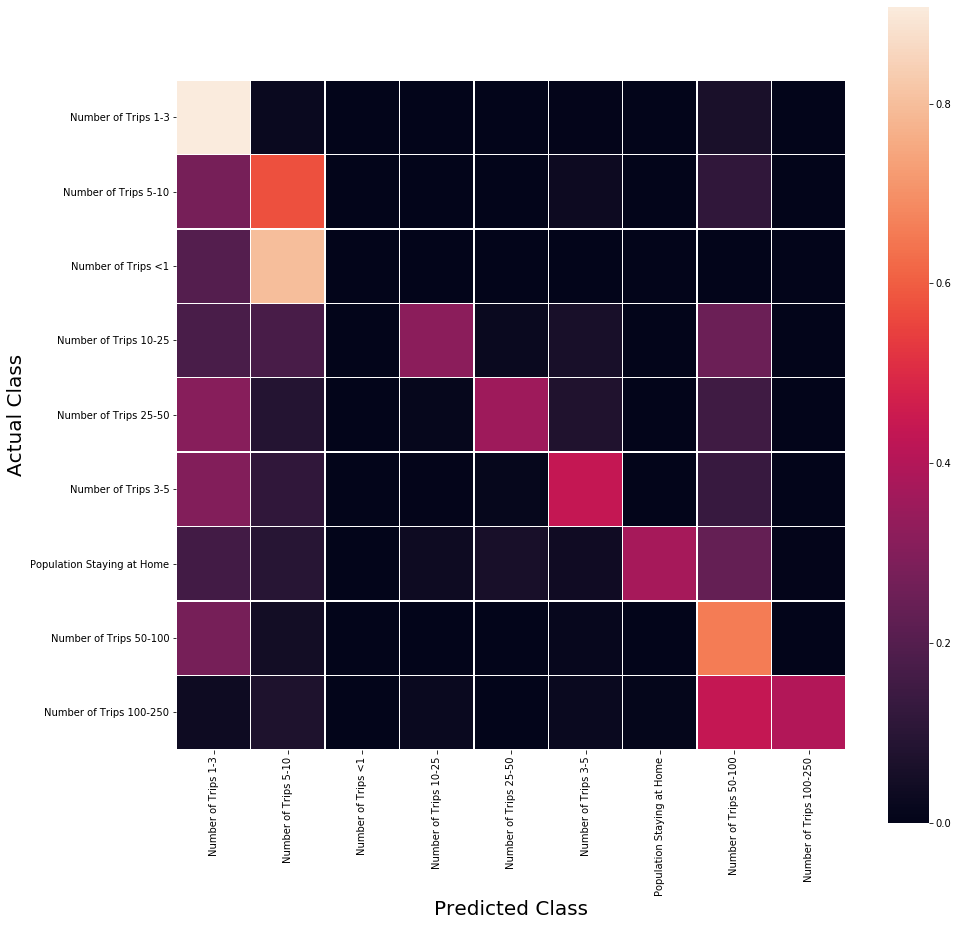

In [15]:
classes = y_test_pre['Max_Trip_Type'].unique()
plot_heatmap(y_test_pre,y_pred_cb_pre,classes, normalize=True)

In [12]:
target_var = 'Max_Trip_Type'
keep_cols = ['weekday','weekend'] + [target_var]
df_mob_train_covid = get_model_df(df_weather, df_mobility,df_covid,df_county,covid=True)

remove_col_list = [col for col in df_mobility.columns if col in df_mob_train_covid and col not in keep_cols]
remove_col_list_COVID = remove_col_list
remove_col_list_COVID.extend(['Lat','Lng'])
df_mob_post_feat_imp_covid,y_test_covid,y_pred_cb_covid,cb_model_covid = run_model_class(df_mob_train_covid,'Post', target_var,remove_col_list,task_type='GPU',max_depth = 6)
df_mob_post_feat_imp_covid.sort_values('Post_Covid_Feature_Importance',ascending=False)[:20]

0:	learn: 0.5703034	total: 107ms	remaining: 26.7s
50:	learn: 0.7222785	total: 5.31s	remaining: 20.7s
100:	learn: 0.7528303	total: 10.6s	remaining: 15.6s
150:	learn: 0.7641701	total: 15.9s	remaining: 10.4s
200:	learn: 0.7705973	total: 21.1s	remaining: 5.15s
249:	learn: 0.7750595	total: 26.2s	remaining: 0us
0.77


,Post_Covid_Feature_Importance
case_rate,3.578044
STATE,2.878737
weekday,2.644382
"Means of Transportation to Work_Car, truck, or van",1.676684
Travel Time to Work_20 to 24 minutes,1.582547
Sex by Age_Male 55 to 59 years,1.528699
Travel Time to Work_10 to 14 minutes,1.503651
DewPointC,1.496121
Travel Time to Work_5 to 9 minutes,1.435739
Means of Transportation to Work_Public transportation (excluding taxicab) Bus or trolley bus,1.390465


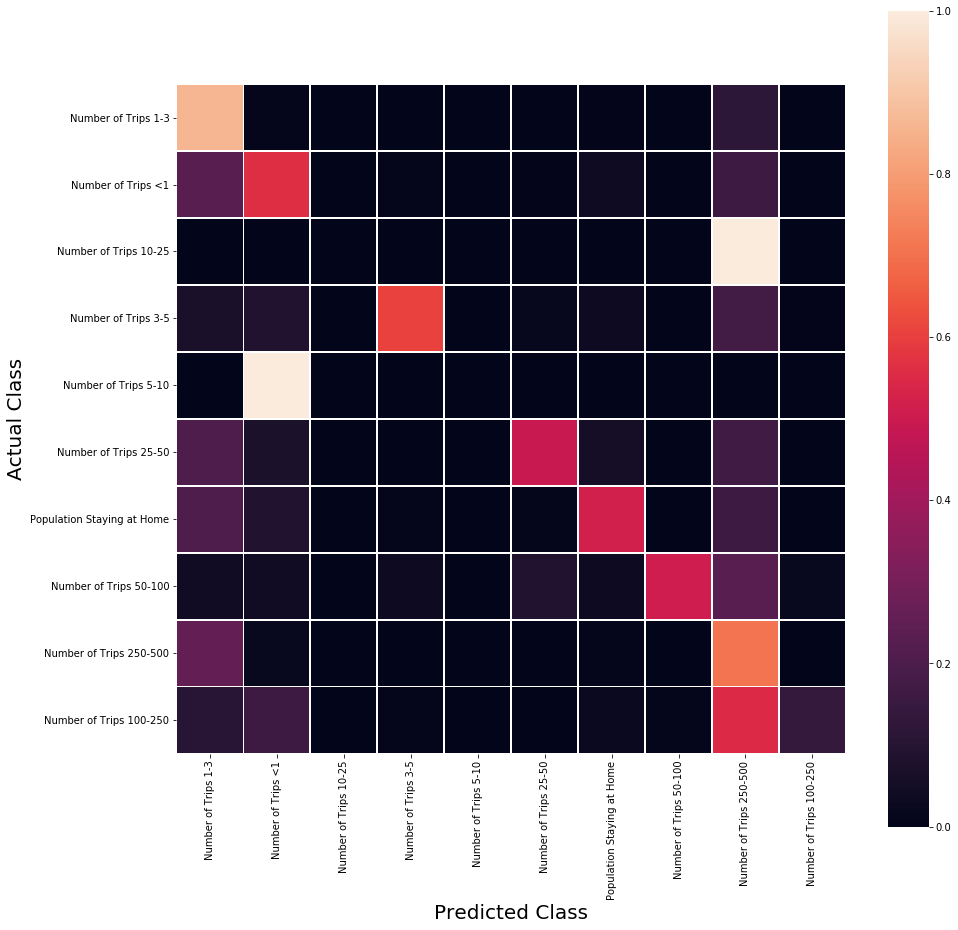

In [16]:
classes = y_test_covid['Max_Trip_Type'].unique()
plot_heatmap(y_test_covid,y_pred_cb_covid,classes, normalize=True)